In [10]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
%config InlinBackend.figure_format="retina"
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负

In [11]:
#生成大气湍流模糊核
def turbulence_PSF(input,k):
    [m, n] = input.shape
    PSF = np.zeros((m, n))
    p = m / 2
    q = n / 2
    for u in range(m):
        for v in range(n):
            PSF[u, v]=math.exp(-k*((u-p)*(u-p)+(v-q)*(v-q))**(5/6))
    PSF1= np.fft.ifft2(PSF)
    PSF1 = np.abs(PSF1)
    PSF1 = PSF1 / PSF1.sum()  # 模糊核的权重和为1
    return PSF1

In [12]:
#此函数生成的运动模糊核是由旋转来控制运动方向
def make_PSF(kernel_size=15, angle=60):
    PSF = np.diag(np.ones(kernel_size))  # 初始模糊核的方向是-45度
    angle = angle + 45  # 抵消-45度的影响
    #图像旋转是一种几何变换，实现图像几何变换有两步：先生成变换算子，再执行变换
    M = cv2.getRotationMatrix2D((kernel_size / 2, kernel_size / 2), angle, 1)  # 生成旋转算子
    PSF = cv2.warpAffine(PSF, M, (kernel_size, kernel_size),flags=cv2.INTER_LINEAR)
    PSF = PSF / PSF.sum()    #模糊核的权重和为1
    return PSF

In [13]:
#此函数扩展PSF0，使之与image0一样大小
def extension_PSF(image0,PSF0):
    [img_h,img_w] = image0.shape
    [h,w] = PSF0.shape
    PSF=np.zeros((img_h,img_w))
    PSF[0:h, 0:w] =PSF0[0:h, 0:w]
    return PSF

In [26]:
# 在频域对图片进行模糊
def make_blurred(input, PSF):
    input_fft = np.fft.fft2(input)  # 进行二维数组的傅里叶变换
    PSF_fft = np.fft.fft2(PSF)
    blurred = np.fft.ifft2(input_fft * PSF_fft)
    blurred=np.abs(blurred)
    return blurred

In [27]:
def inverse(input, PSF):  # 逆滤波
    input_fft = np.fft.fft2(input)
    PSF_fft = np.fft.fft2(PSF)+1e-3  # 为了避免分母为零，将PSF的傅里叶变换加一个极小值eps
    result = np.fft.ifft2(input_fft / PSF_fft)  # 
    result = np.abs(result)
    return result.copy()

In [28]:
# 伪逆滤波
def Pseudo_inverse(input, PSF, w,k):  
    input_fft = np.fft.fft2(input)
    input_sfft=np.fft.fftshift(input_fft)
    PSF_fft = np.fft.fft2(PSF)  
    PSF_sfft=np.fft.fftshift(PSF_fft)
    [M,N]=input_fft.shape
    c0=int((M-1)/2)
    c1=int((N-1)/2)    
    F=np.zeros((M,N))+0j
    for u in range(M):
        for v in range(N):
            D=np.sqrt((u-c0)**2+(v-c1)**2)
            if D<=w:
                F[u,v] = input_sfft[u,v] / PSF_sfft[u,v]
            else:
                F[u,v]=k*input_sfft[u,v]
#     F=input_sfft / PSF_sfft
#     print(F)
    result=np.fft.ifft2(np.fft.fftshift(F))
    return np.abs(result)

In [30]:
def wiener(input, PSF,K=1e-3):  # 维纳滤波，K=0.01
    input_fft = np.fft.fft2(input)
    PSF_fft = np.fft.fft2(PSF)
    PSF_fft_1 = np.conj(PSF_fft) / (np.abs(PSF_fft) ** 2 + K)
    result = np.fft.ifft2(input_fft * PSF_fft_1)
    result = np.abs(result)
    # result = np.abs(fft.fftshift(result))
    return result

In [31]:
def clsFilter(image, PSF,Q,lambd=1e-3):    
    input_fft = np.fft.fft2(image)
    PSF_fft = np.fft.fft2(PSF)
    Q_fft = np.fft.fft2(Q)
    PSF_fft_1 = np.conj(PSF_fft) / (np.abs(PSF_fft) ** 2 + lambd*np.abs(Q_fft)**2)
    result = np.fft.ifft2(input_fft * PSF_fft_1)
    result = np.abs(result)
    # result = np.abs(fft.fftshift(result))
    return result

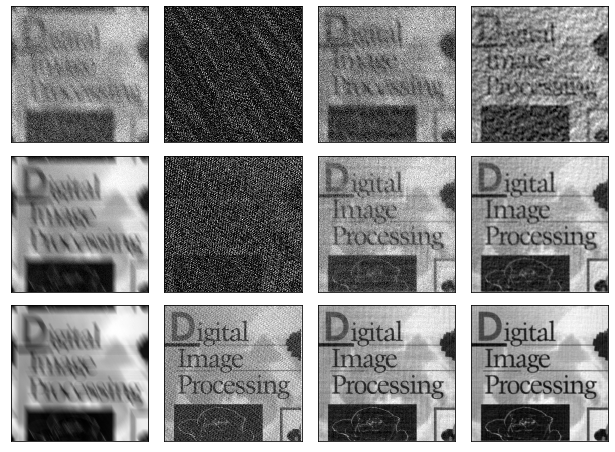

In [103]:
image =cv2.imread('../img/adip.png',0)
PSF0 = make_PSF(20, -60)          #生成运动模糊核
PSF = extension_PSF(image,PSF0)    #扩展psf，使其大小与图像大小一致，卷积运算有轻微混迭
blurred = np.abs(make_blurred(image, PSF))  #在频域对图片进行运动模糊
#产生最小二乘滤波需要的锐化算子
lap0=np.array([[0,1,0],[1,-4,1],[0,1,0]])
lap = extension_PSF(image,lap0)
fig,axes=plt.subplots(3,4,sharex=True,sharey=True,figsize=(11,8))
w=0.5
for i in range(3):
    # 添加不同强度的噪声,standard_normal产生随机的函数
    blurred_noisy = blurred + w * blurred.std() * \
                    np.random.standard_normal(blurred.shape)  
    imgRI=inverse(blurred_noisy, PSF)
    imgRW=wiener(blurred_noisy, PSF, w/10)
    imgRC=clsFilter(blurred_noisy, PSF, lap,w/10)    
    axes[i,0].imshow(blurred_noisy,cmap="gray"),plt.xticks([]), plt.yticks([])
    axes[i,1].imshow(imgRI,cmap="gray"),plt.xticks([]), plt.yticks([])
    axes[i,2].imshow(imgRW,cmap="gray"),plt.xticks([]), plt.yticks([])
    axes[i,3].imshow(imgRC,cmap="gray"),plt.xticks([]), plt.yticks([])
    w/=10
plt.subplots_adjust(wspace=0,hspace=0.1)
plt.show()

In [101]:
# CLSFilter调参代码
from chap2_evaluationIndix import *
k=1e-4
for i in range(10):
    imgRC=clsFilter(blurred_noisy, PSF, lap,k) 
    p1=PSNR(image,imgRC)
    print(k,p1)        
    k*=2

0.0001 34.61770315073734
0.0002 33.82379095745061
0.0004 32.54691457539453
0.0008 31.146456146418412
0.0016 29.8248139432485
0.0032 28.637590333997267
0.0064 27.5808305647308
0.0128 26.627202887506392
0.0256 25.736855926593442
0.0512 24.889046656525107
